In [1]:
import warnings
from pathlib import Path
import json
import re
from multiprocessing import Pool

import numpy as np  
from scipy.optimize import minimize, OptimizeWarning, show_options

import emcee
from emcee.autocorr import AutocorrError
import corner

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import ufloat
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia

from dust_extinction.parameter_averages import F99, F04, G23

from deblib.constants import M_sun, R_sun
from deblib.stellar import log_g

from libs import extinction
from libs.pipeline import get_teff_from_spt
from libs.sed import get_sed_for_target, create_outliers_mask, group_and_average_fluxes
from libs.sed import calculate_vfv
from libs.pyssed import ModelSed

### Load the PySSED bt-settle model and set up the related model functions 

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

First we load the pre-built data of bt-settle synthetic SED which have previously been parsed
and saved with the `makemodel.py` module. The data file contains fluxes over a range of filters
for combinations of $T_{\rm eff}$, $\log{g}$, $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$. We build a
table in memory which holds a `RegularGridInterpolator` for each filter, with the dimensions/axes
being the $T_{\rm eff}$ and $\log{g}$ values and the values being the corresponding fluxes.

For now we consider only the data for solar metallicity, hence the interpolators only cover
$[{\rm Fe/H}] = 0$ and $[{\rm \alpha/Fe}] = 0$, however additional axes/dimensions
for $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$ may be added, if required.

In [2]:
# Read the pre-built bt-settl model file
model_sed = ModelSed("libs/data/pyssed/model-bt-settl-recast.dat")

print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_sed.wavelength_range:unicode}, Teff {model_sed.teff_range:unicode}",
      f"and logg {model_sed.logg_range:unicode}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.3 22. ] µm, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


### Set up the extinction model

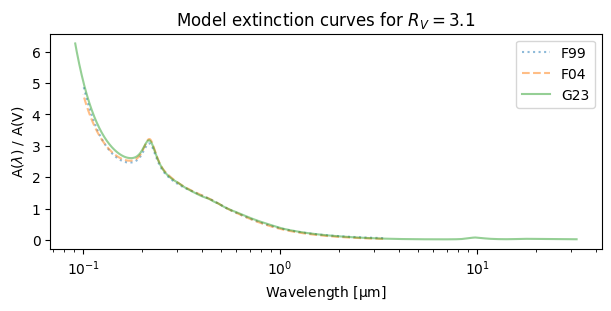

Using the G23 extinction model covers the range from 0.0912 µm to 32.0 µm.


In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=f"Wavelength [{_lambda.unit:latex_inline}]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

### Select our target and get its known information

In [4]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(model_sed.teff_range).to(u.K).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

In [5]:
target = target_selection.value
target_config = targets_cfg[target]
target_config.setdefault("loggA", log_g(target_config["MA"] * M_sun, target_config["RA"] * R_sun).n)
target_config.setdefault("loggB", log_g(target_config["MB"] * M_sun, target_config["RB"] * R_sun).n)
# Additional data on the target populated with lookups
target_data = { }
target_data["label"] = target_config.get("label", target)
target_data["search_term"] = target_config.get("search_term", target)

_simbad = Simbad()
_simbad.add_votable_fields("sp", "ids")
if _tbl := _simbad.query_object(target_data["search_term"]):
    target_data["ids"] = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                                    dtype=[("type", object), ("id", object)])
    print(f"IDs:", ", ".join(f"{i['type']} {i['id']}" for i in target_data["ids"]))
    target_data["spt"] = _tbl["sp_type"][0]
    print(f"SpT:", target_data["spt"])

IDs: Gaia DR3 1431176943768690816, TIC 199574209, TIC 199574208, 2MASS J16342040+5709439, V* CM Dra, 2MASS J16342041+5709489
SpT: M4.5V


In [6]:
# Let's get the Gaia DR3 data on this here object
_gaia_dr3_id = target_data["ids"][target_data["ids"]["type"] == "Gaia DR3"]["id"][0]
if _job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}"):
    _tbl = _job.get_results()
    target_data["parallax_mas"] = ufloat(_tbl["parallax"][0], _tbl["parallax_error"][0])
    target_data["skycoords"] = _coords = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                                  distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
    print(f"{target} SkyCoords are {_coords} (or {_coords.to_string('hmsdms')})")
    target_data["bp_rp"] = _tbl["bp_rp"][0]
    target_data["phot_g_mean_mag"] = _tbl["phot_g_mean_mag"][0]
    target_data["ruwe"] = _tbl["ruwe"][0]

CM Dra SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (248.57558061, 57.16757382, 14.86158398)> (or 16h34m18.13934594s +57d10m03.26574348s)


In [7]:
# Lookup the TESS Input Catalog (8.2) for starting "system" Teff and logg values
target_data["teff_sys"] = get_teff_from_spt(target_data["spt"]) or ufloat(5700, 0)
target_data["logg_sys"] = ufloat(4.0, 0)
if _tbl := Vizier(catalog="IV/39/tic82").query_object(target_data["search_term"], radius=0.1 * u.arcsec):
    if _row := _tbl[0][_tbl[0]["TIC"] in target_data["ids"][target_data["ids"]["type"] == "TIC"]["id"]]:
        # Teff may not be reliable - only use it if it's consistent with the SpT
        if target_data["teff_sys"].n-target_data["teff_sys"].s < (_row["Teff"] or 0) < target_data["teff_sys"].n+target_data["teff_sys"].s:
            target_data["teff_sys"] = ufloat(_row["Teff"], _row.get("s_Teff", None) or 0)
        if (_row["logg"] or 0) > 0:
            target_data["logg_sys"] = ufloat(_row["logg"], _row.get("s_logg", None) or 0)

# Other priors will likely come out of light curve fitting with JKTEBOP - get from config for now
target_data["k"] = ufloat(target_config.get("k"), target_config.get("k_err", 0) or 0)
# If from LC fit we may also need to consider l3; lA=(1-l3)/(1+(LB/LA)) & lB=(1-l3)/(1+1/(LB/LA))
target_data["light_ratio"] = ufloat(10**(target_config.get("logLB", 1) - target_config.get("logLA", 1)), 0)
target_config["light_ratio"] = target_data["light_ratio"].n
target_config["light_ratio_err"] = target_data["light_ratio"].s
target_data["teff_ratio"] = (target_data["light_ratio"] / target_data["k"]**2)**0.25

print(f"{target} system values from lookup and LC fitting:")
for p, unit in [("teff_sys", u.K), ("logg_sys", u.dex), ("k", None), ("light_ratio", None), ("teff_ratio", None)]:
    print(f"{p:>12s} = {target_data[p]:.3f} {unit or u.dimensionless_unscaled:unicode}")

CM Dra system values from lookup and LC fitting:
    teff_sys = 3214.000+/-157.000 K
    logg_sys = 4.906+/-0.004 dex
           k = 0.945+/-0.001 
 light_ratio = 0.881+/-0 
  teff_ratio = 0.997+/-0.000 


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- remove duplicate SED measurements
- group and average SED measurements by filter & frequency
- exclude measurements outside the range of our extinction model
- optionally exclude flux outliers

In [8]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Work in Jy rather than W/m^2/Hz as they are a more natural unit, giving values that minimize 
# potential FP rounding. Plots are agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, target_data["search_term"], radius=0.1, remove_duplicates=True,
                         freq_unit=u.GHz, flux_unit=u.Jy, wl_unit=u.um, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= np.array([model_sed.has_filter(f) for f in sed["sed_filter"]])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_sed.wavelength_range)) & (sed["sed_wl"] <= max(model_sed.wavelength_range))
sed = sed[model_mask]

# Optionally, filter out outliers
out_mask = np.zeros_like(model_mask[model_mask], dtype=bool) 
#out_mask |= create_outliers_mask(sed, theta0[:2], min_unmasked=15, verbose=True)
sed = sed[~out_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table cm-dra-0.1.vot containing 28 row(s).
Dropped 10 duplicate(s) leaving 18 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 12 group(s) from 18 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
11 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being Jy, GHz, µm


### De-redden the SED
Use the target coordinates to find an $E(B-V)$ value from the available extinction maps.
With this we can deredden the remaining SED fluxes using the previously created extinction model. 

In [9]:
for val, flags in extinction.get_ebv(target_data["skycoords"], rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.906 s
  pix_info:   0.346 s
   samples:  14.471 s
      best:   2.672 s
       nan:   0.018 s
      sort:   8.330 s
       idx:   0.069 s
Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data.
Found extinction with get_vergely_av: E(B-V) = 0.000515


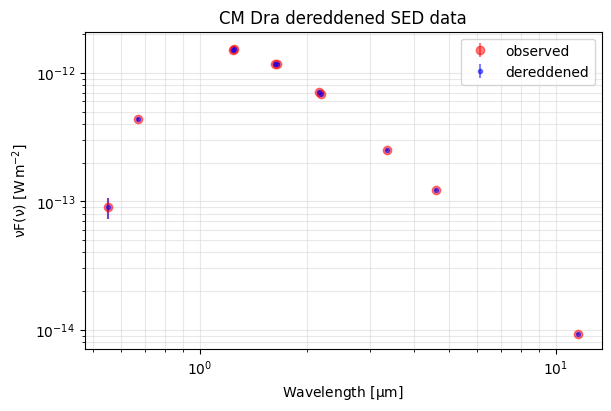

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, unit=u.W/u.m**2), fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, flux_colname="sed_der_flux", unit=u.W/u.m**2), fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"{target_data['label']} dereddened SED data",
       xscale="log", xlabel=f"Wavelength [{u.um:latex_inline}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{u.W/u.m**2:latex_inline}]")
ax.grid(True, which="both", axis="both", alpha=0.5, color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Set up the functions which will support fitting

First we set the starting position for the fit, `theta0`, which is our best estimate of the
fitted values for the system based on existing published data and any light-curve fitting carried
out previously.

In [11]:
if target_data["teff_ratio"].n <= 1:
    theta0 = [target_data["teff_sys"].n, (target_data["teff_sys"]*target_data["teff_ratio"]).n,
              target_data["light_ratio"].n]
else:
    theta0 = [(target_data["teff_sys"]/target_data["teff_ratio"]).n, target_data["teff_sys"].n,
              target_data["light_ratio"].n]

theta_plot_labels = [r"$T_{\rm eff,A}$", r"$T_{\rm eff,B}$", r"$L_{\rm B} / L_{\rm A}$"]
theta_labels = [("TeffA", model_sed.teff_range.unit), ("TeffB", model_sed.teff_range.unit),
                ("light_ratio", u.dimensionless_unscaled)]
print(f"For {target} we set the starting position (theta0) to be:",
    *(f"\n{l:>12s} = {theta0[ix]: .3f} {unit:unicode}" for ix, (l, unit) in enumerate(theta_labels)))

# Fix the logg values for the components to "reasonable" M-S values
#sed_logg = [target_data["logg_sys"].n] * 2
sed_logg = [4.0, 4.0]
print(f"The logg values are fixed at [{', '.join(f'{l:.3f}' for l in sed_logg)}].")

For CM Dra we set the starting position (theta0) to be: 
       TeffA =  3214.000 K 
       TeffB =  3203.170 K 
 light_ratio =  0.881 
The logg values are fixed at [4.000, 4.000].


The **model_func** will calculate a set of model SED flux data at points `x` for a given `theta`.
The implementation `scaled_summed_model(x, theta)` scales these model data to the known SED
fluxes before returning them.

We also set up the goodness of fit function here, which will return a weighted $\chi^2$ value.

In [12]:
# These are the functions for generating synthetic spectra and combining them into a model
flux_unit = sed["sed_der_flux"].unit
y_log = np.log10(sed["sed_der_flux"].quantity.value)

def scaled_summed_model(theta, x, logg=sed_logg):
    (teffA, teffB, lr), (loggA, loggB) = theta, logg
    lA = 1 / (1 + lr)
    lB = 1 - lA

    # Scale the model to the obs' in log10 space as the range of potential values is very wide
    y_model_log = np.log10(np.add(
        model_sed.get_fluxes(x, teffA, loggA).value * lA,
        model_sed.get_fluxes(x, teffB, loggB).value * lB))
    if flux_unit != u.Jy and model_sed.flux_unit == u.Jy:
        y_model_log -= 26
    return 10**(y_model_log + np.median(y_log - y_model_log))

def weighted_chi_sq(y_model, y, w, degree_freedom=len(y_log)-len(theta0)) -> float:
    """ chi^2_w = 1/(N_obs-n_param) * Σ W(y-y_model)^2 """
    return np.sum(w * (y - y_model)**2) / degree_freedom

Here we set up the known priors and the **ln_prior_func** which will be called during fitting
to return how well the current `theta` conforms to the prior criteria (returning a finite negative
value), or not (returning -np.inf).

In [13]:
MIN_TEFF, MAX_TEFF = model_sed.teff_range.to(u.K).value
print(f"Priors from synthetic data:\t{MIN_TEFF} < T_eff < {MAX_TEFF} [K]")

# Target specific priors originating from LC fit
_teff_ratio = target_data["teff_ratio"].n
_teff_ratio_sigma = max(_teff_ratio * 0.05, target_data["teff_ratio"].s)
_light_ratio = target_data["light_ratio"].n
_light_ratio_sigma = max(_light_ratio * 0.05, target_data["light_ratio"].s)
print(f"Priors from LC fitting:\t\tT_eff ratio={_teff_ratio:.6f} +/- flex of {_teff_ratio_sigma:.6f},",
      f"light_ratio={_light_ratio:.6f} +/- sigma of {_light_ratio_sigma:.6f}")

def ln_prior_func(theta) -> float:
    teffA, teffB, lr = theta
    # Uniform priors - the conditions are either met or not.
    if not all(MIN_TEFF < t < MAX_TEFF for t in [teffA, teffB]):
        return -np.inf

    # Gaussian priors: g(x) = 1/(σ*sqrt(2*pi)) * exp(-1/2 * (x-µ)^2/σ^2)
    # Omitting the scaling expressions for now and note the implicit log cancelling the exp.
    return -0.5 * (((teffB/teffA - _teff_ratio) / _teff_ratio_sigma)**2 \
                + ((lr - _light_ratio) / _light_ratio_sigma)**2)

Priors from synthetic data:	1900.0 < T_eff < 70000.0 [K]
Priors from LC fitting:		T_eff ratio=0.996630 +/- flex of 0.049832, light_ratio=0.881049 +/- sigma of 0.044052


The **ln_prob_func** is the function which will be maximized by MCMC fitting. It pulls together
`ln_prior_func` to evaluate the current `theta` against the prior criteria and the goodness of
fit function which calculates the $\chi^2$ value of the `scaled_summed_model` (based on `theta`)
against the observations.

We also set up the static values to be passed to each iteration of the **ln_prob_func**. These
are the filters (x) and fluxes (y) of the SED observations and the weights to apply to the $\chi^2$
goodness func (w). These last default to 1/variance, leading to a reduced-$\chi^2$ goodness value.

In [14]:
def ln_prob_func(theta, x, y, w) -> float:
    """
    This is the function to be optimized to fit a model to the SED data

    :theta: the current set of parameters being fitted
    :x: the filters used for each of the observed fluxes
    :y: the observed fluxes
    :w: the weights to use for the weighted chi^2 evaluation
    :returns: a single value representing the likeness between the model and observations
    """
    if np.isfinite(retval := ln_prior_func(theta)):
        retval -= weighted_chi_sq(scaled_summed_model(theta, x), y, w)
        retval = np.nan_to_num(retval, nan=-np.inf)
    return retval

# Weights for chisq eval; with default of mod==1 we have 1/var, effectively giving us reduced chisq
# This approach to generating the weights allows us to weight towards observations near the BB peak.
_bb_peak_lambda = 2.897771955e3 / target_data["teff_sys"].n # um
_sed_lambda = sed["sed_wl"].to(u.um).value
_wt_mod = 1 / 1**abs((_sed_lambda - _bb_peak_lambda) / (_sed_lambda.max() - _bb_peak_lambda))
_wt = _wt_mod / sed["sed_eflux"].quantity.value**2
print(f"The fitting chisq weights are calculated as [", ", ".join(f"{m:.3f}" for m in _wt_mod),
      "] / sed_eflux^2\ngiving [", ", ".join(f"{w:.3e}" for w in _wt), "]")

# Everything after theta in the arg list is effectively fixed for each fitting - set them now
obj_args = ( # x, y, W
    model_sed.get_filter_indices(sed["sed_filter"]),
    sed["sed_der_flux"].quantity.value,
    _wt
)

The fitting chisq weights are calculated as [ 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000 ] / sed_eflux^2
giving [ 1.041e+05, 2.150e+05, 6.944e+03, 9.406e+02, 4.444e+03, 4.444e+03, 1.000e+04, 1.000e+04, 2.778e+04, 1.111e+05, 4.000e+06 ]


### Run the initial "minimize" fit

In [15]:
with warnings.catch_warnings(category=[RuntimeWarning, OptimizeWarning]):
    warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
    warnings.filterwarnings("ignore", message="Desired error not necessarily achieved due to precision loss.")
    warnings.filterwarnings("ignore", message="Unknown solver options:")

    _soln, _soln_type = None, None
    for method in [None, "Nelder-Mead", "SLSQP"]:
        # Unlike MCMC, the minimize seeks to minimize the response of the objective/ln_prob_func
        this_soln = minimize(lambda theta, x, y, w: -ln_prob_func(theta, x, y, w), x0=theta0,
                             args=obj_args, method=method, options={ "maxiter": 1e4, "maxfev": 1e4 })      
        print(f"(method={method}) {'succeed' if this_soln.success else 'fail'}ed [{this_soln.message}] after",
            f"{this_soln.nit} iteration(s) & {this_soln.nfev} function evaluation(s) [fun = {this_soln.fun:.6f}]")
        if _soln is None or (not _soln.success and this_soln.success) or (_soln.fun > this_soln.fun):
            _soln, _soln_type = this_soln, method

# Read the resulting fitted values
print(f"Using the best fit which is from {_soln_type}")
theta_fit = _soln.x
theta_err_high = np.zeros_like(_soln.x, dtype=float)
theta_err_low = np.zeros_like(_soln.x, dtype=float)

(method=None) failed [Desired error not necessarily achieved due to precision loss.] after 16 iteration(s) & 552 function evaluation(s) [fun = 10.584708]
(method=Nelder-Mead) succeeded [Optimization terminated successfully.] after 170 iteration(s) & 308 function evaluation(s) [fun = 10.584707]
(method=SLSQP) succeeded [Optimization terminated successfully] after 17 iteration(s) & 102 function evaluation(s) [fun = 10.584714]
Using the best fit which is from Nelder-Mead


In [16]:
def plot_fitted_model(theta, logg=sed_logg):
    filter_ixs = model_sed.get_filter_indices(sed["sed_filter"])
    flux_unit = sed["sed_der_flux"].unit
    sed_wl = sed["sed_wl"].to(u.um)
    
    # The baseline dereddened observed SED data in nu*F(nu) form
    obs_der_vfv, obs_der_evfv = calculate_vfv(sed, flux_colname="sed_der_flux", unit=u.W / u.m**2)

    # Generate a model SED from the fitted values in nu*F(nu) form for plotting
    mod_comb_vfv = (scaled_summed_model(theta, filter_ixs, logg) * flux_unit \
                    * sed["sed_freq"].quantity).to(obs_der_vfv.unit)
    lA = 1 / (1 + theta[-1])
    mod_starA_vfv = mod_comb_vfv * lA
    mod_starB_vfv = mod_comb_vfv * (1 - lA)

    # Plot the fitted model against the derredened SED + show each star's contribution
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
    for (lam,       flux,               eflux,              fmt,    alpha,  z,      label) in [
        (sed_wl,    obs_der_vfv,        obs_der_evfv,       "ob",   0.5,    50,     "dereddened SED"),
        (sed_wl,    mod_comb_vfv,       None,               ".k",   0.66,   90,     "fitted pair"),
        (sed_wl,    mod_starA_vfv,      None,               "*g",   0.66,   80,     "fitted star A"),
        (sed_wl,    mod_starB_vfv,      None,               "xr",   0.66,   70,     "fitted star B"),
    ]:
        ax.errorbar(lam, flux, eflux, fmt=fmt, alpha=alpha, zorder=z, label=label)
    ax.set(title=f"{target_data['label']} dereddened SED and fitted model",
           xscale="log", xlabel=f"Wavelength [{sed_wl.unit:latex_inline}]",
           yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{obs_der_vfv.unit:latex_inline}]")
    ax.grid(True, which="both", axis="both", color="lightgray", alpha=0.5, zorder=0)
    ax.legend(loc="best")
    plt.show(fig)
    plt.close(fig)

Best fit parameters for CM Dra from minimization fit
       TeffA =  3210.398 K (known value 3130.000+/-70.000)
       TeffB =  3200.000 K (known value 3120.000+/-70.000)
 light_ratio =  0.881  (known value 0.881+/-0)


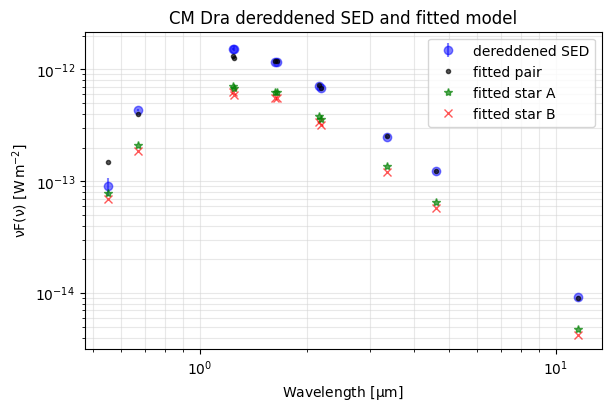

In [17]:
print(f"Best fit parameters for {target} from minimization fit")
for ix, (l, unit) in enumerate(theta_labels):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>12s} = {theta_fit[ix]: .3f} {unit:unicode} (known value {known_val:.3f})")    

plot_fitted_model(theta_fit)

### Perform MCMC fitting for a more reliable fit with uncertainties from a probability distribution

In [18]:
nwalkers, niters = 100, 25000
init_sigma = np.array([1000, 1000, 1]) * 0.05
rng = np.random.default_rng(42)
p0 = [theta0 + rng.normal(0, init_sigma) for _ in range(int(nwalkers))]

with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for up to {niters:,} iterations with {nwalkers} walkers.")
        sampler = emcee.EnsembleSampler(nwalkers, ndim=len(theta0), log_prob_fn=ln_prob_func,
                                        args=obj_args, pool=pool)

        prev_tau = np.inf
        for sample in sampler.sample(initial_state=p0, iterations=niters, progress=True):
            if sampler.iteration % 1000 == 0:
                # autocorrelation time; steps to effectively "forget" start position
                tau = sampler.get_autocorr_time(tol=0)
                if all(tau < sampler.iteration / 100) and all(abs(prev_tau - tau) / tau < 0.01):
                    print(f"Halting the MCMC after {sampler.iteration:,} iterations as we've",
                           "passed 100 times the autocorrelation time and the fit has converged.")
                    break
                prev_tau = tau

Running MCMC for up to 25,000 iterations with 100 walkers.


 28%|██▊       | 7000/25000 [05:21<13:46, 21.79it/s]

Halting the MCMC after 7,000 iterations as we've passed 100 times the autocorrelation time and the fit has converged.


In [19]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction:    {accept_frac:.6f}")

try:
    tau = sampler.get_autocorr_time(c=1)
    print(f"Autocorrelation steps (tau):", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau
burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
print(f"Estimated burn-in steps:     {burn_in_steps:,}")

Mean Acceptance fraction:    0.641190
Autocorrelation steps (tau): 31.720, 31.922, 30.839
Estimated burn-in steps:     63


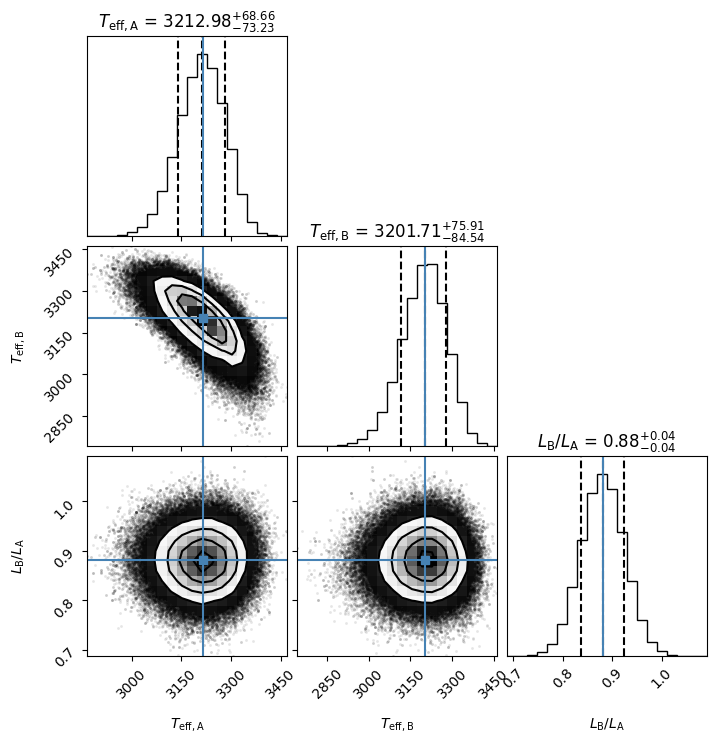

In [20]:
# thin; every nth step from the chain
samples = sampler.get_chain(discard=burn_in_steps, thin=max(1, int(1 / (1-max(accept_frac, 0.1)))), flat=True)
fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                    labels=theta_plot_labels, truths=theta0)
plt.show(fig)
plt.close(fig)

Best fit parameters for CM Dra from subsequent MCMC fit
       TeffA = 3212.983 +/- 68.662/73.231 K (known value 3130.000+/-70.000 K)
       TeffB = 3201.709 +/- 75.909/84.538 K (known value 3120.000+/-70.000 K)
 light_ratio = 0.881 +/- 0.044/0.043  (known value 0.881+/-0 )


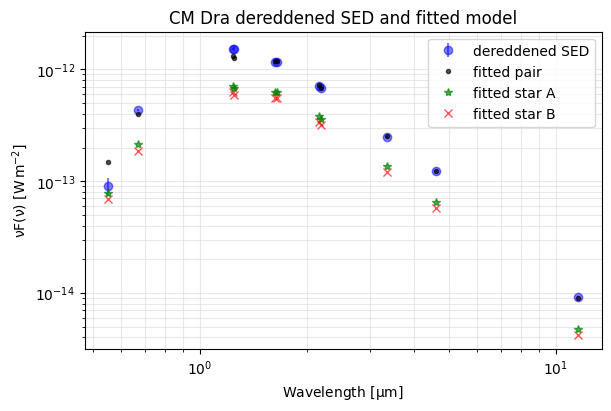

In [21]:
# Gets the median fitted values (currently M1, M2 and log(age))
theta_fit = np.median(samples[burn_in_steps:], axis=0)
theta_err_high = np.quantile(samples[burn_in_steps:], 0.84, axis=0) - theta_fit
theta_err_low = theta_fit - np.quantile(samples[burn_in_steps:], 0.16, axis=0)

print(f"Best fit parameters for {target} from subsequent MCMC fit")
for ix, (l, unit) in enumerate(theta_labels):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>12s} = {theta_fit[ix]:.3f} +/- {theta_err_high[ix]:.3f}/{theta_err_low[ix]:.3f}",
          f"{unit:unicode} (known value {known_val:.3f} {unit:unicode})") 

plot_fitted_model(theta_fit)